# Process Bigraph Diagrams for Tumor-Tcell ABM

In [24]:
import copy
from bigraph_viz import plot_bigraph, plot_multitimestep, convert_vivarium_composite
from bigraph_viz.dict_utils import replace_regex_recursive
from tumor_tcell.experiments.main import large_experiment
from vivarium.core.engine import pf
from vivarium.core.composer import Composite

plot_settings = {}
save_images = False
if save_images:
    plot_settings.update({'out_dir': 'out','dpi': '250'})
    
plot_settings2={}
if save_images:
    plot_settings2.update({
        'out_dir': 'out',
        'dpi': '250'
    })

def get_in(dict, path):
    if path:
        dict = get_in(dict[path[0]], path[1:]) 
    return dict

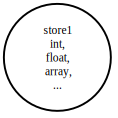

In [25]:
typed_store_spec = {
    'store1': {
        '_value': 'int, float, array, ...'}}

# plot
plot_bigraph(replace_regex_recursive(typed_store_spec), **plot_settings, show_values=True, show_types=True, filename='store')

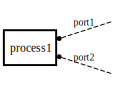

In [26]:
process_spec = {
    '_type': 'python_process',
    'process1': {
        '_type': 'edge',
        '_ports': {
            'port1': 'Any',
            'port2': 'Any'}}}

# plot
plot_bigraph(process_spec, **plot_settings, rankdir='RL', filename='process')

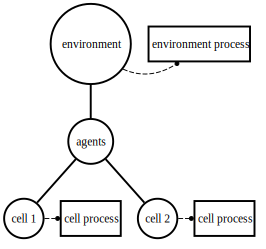

In [27]:
agent_spec = {
    'cell process': {
        'wires': {
            'port1': [],}}}

abm_spec = {
    'environment': {
        'agents': {
            'cell 1': agent_spec,
            'cell 2': agent_spec}},
    'environment process': {
        'wires': {
            'port1': 'environment'}}}

# plot
node_groups = [
    [('environment',), ('environment process',)],
    [('environment', 'agents', 'cell 1'), ('environment', 'agents', 'cell 1', 'cell process',)],
    [('environment', 'agents', 'cell 2'), ('environment', 'agents', 'cell 2', 'cell process',)],
]
plot_bigraph(abm_spec, **plot_settings, node_groups=node_groups, port_labels=False, remove_process_place_edges=True, filename='abm_composite')

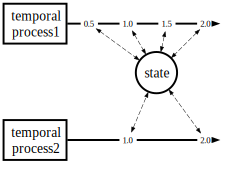

In [28]:
multitimestep_spec = {
    'temporal process2': {
        '_ports': {'port1': 'Any'},
        'wires': {'port1': 'state'},
        '_sync_step': 1.0,
    },
    'temporal process1': {
        '_ports': {'port1': 'Any'},
        'wires': {'port1': 'state'},
        '_sync_step': 0.5,
    },
}
multitimestep_spec = replace_regex_recursive(multitimestep_spec)
plot_multitimestep(multitimestep_spec, total_time=2.0, **plot_settings2, filename='multitimestep')

## Full ABM

In [66]:
# get the experiment
data, experiment = large_experiment(
        n_tcells=1,
        n_tumors=1,
        n_dendritic=1,
        n_tcells_lymph_node=0,
        tumors_state_PDL1n=0.5,
        tcells_total_PD1n=8,
        dendritic_state_active=0.5,
        lymph_nodes=True,
        total_time=0, 
        field_molecules=['IFNg', 'tumor_debris'],
        return_experiment=True,
    )

# make a composite from the experiment
composite = Composite(
    state=experiment.state.get_value(), 
    processes=experiment.state.get_processes(), 
    steps=experiment.state.get_steps(), 
    topology=experiment.state.get_topology(), 
    flow=experiment.state.get_flow(),
)
del composite['_schema']
del composite['state']

# convert to a bigraph spec for visualization
abm_experiment_spec = convert_vivarium_composite(composite)

Initializing experiment tumor_tcell_20231026.222910


0it [00:00, ?it/s]

Completed in 0.00 seconds


In [67]:
# tidy up
lymph_node_transfer = {'lymph_node_transfer': {'wires': experiment.state.get_value()['lymph_node_transfer'][1]}}
abm_experiment_spec.update(lymph_node_transfer)
del abm_experiment_spec['tumor_environment']['death_log']
del abm_experiment_spec['tumor_environment']['log']
del abm_experiment_spec['tumor_environment']['clock']
del abm_experiment_spec['tumor_environment']['global_time']

node_groups = [
    [
        ('tumor_environment',), 
        ('in_transit',), ('lymph_node',), 
        ('lymph_node_transfer',)],
    [
        ('tumor_environment', 'dimensions',), 
        ('tumor_environment', 'fields',), 
        ('tumor_environment', 'agents',), 
        # ('tumor_environment', 'diffusion_field',), 
        # ('tumor_environment', 'neighbors_multibody',), 
    ],
]

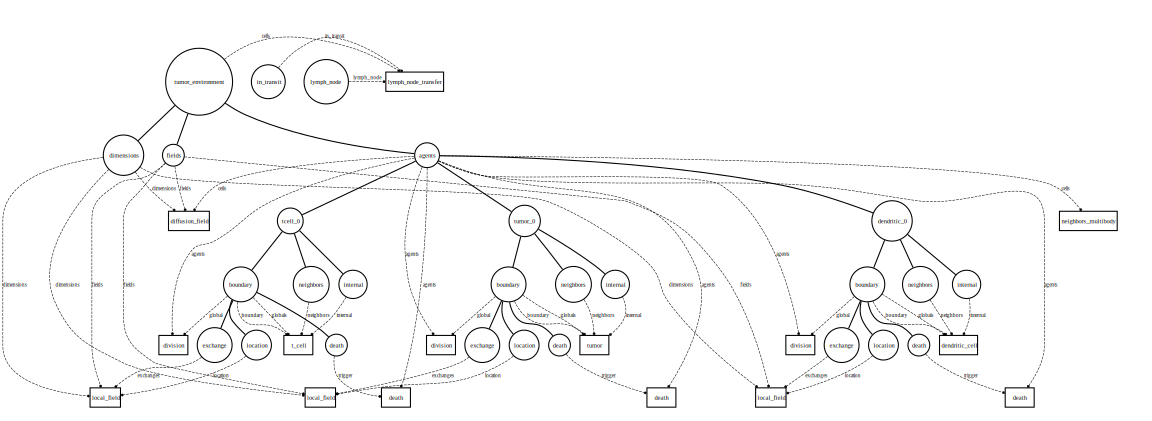

In [68]:
c1 = 'orange'
c2 = 'cyan'
c3 = 'orchid'
c4 = 'limegreen'
node_colors0 = {
    ('tumor_environment',): c1,
    ('in_transit',): c1,
    ('lymph_node',): c1,
}
node_colors1 = {
    ('tumor_environment', 'agents', 'tcell_0'): c3,
    ('tumor_environment', 'agents', 'dendritic_0'): c3,
    ('tumor_environment', 'agents', 'tumor_0'): c3,
}
node_colors2 = {
    ('tumor_environment', 'agents',): c2,
    ('tumor_environment', 'fields'): c2,
    ('tumor_environment', 'dimensions'): c2,
}

plot_bigraph(abm_experiment_spec, 
             **plot_settings,
             node_groups=node_groups,
             # node_fill_colors={**node_colors0, **node_colors1, **node_colors2},
             remove_process_place_edges=True,
             filename='abm_experiment_full',
             # **{'out_dir': 'out','dpi': '250'}
            )

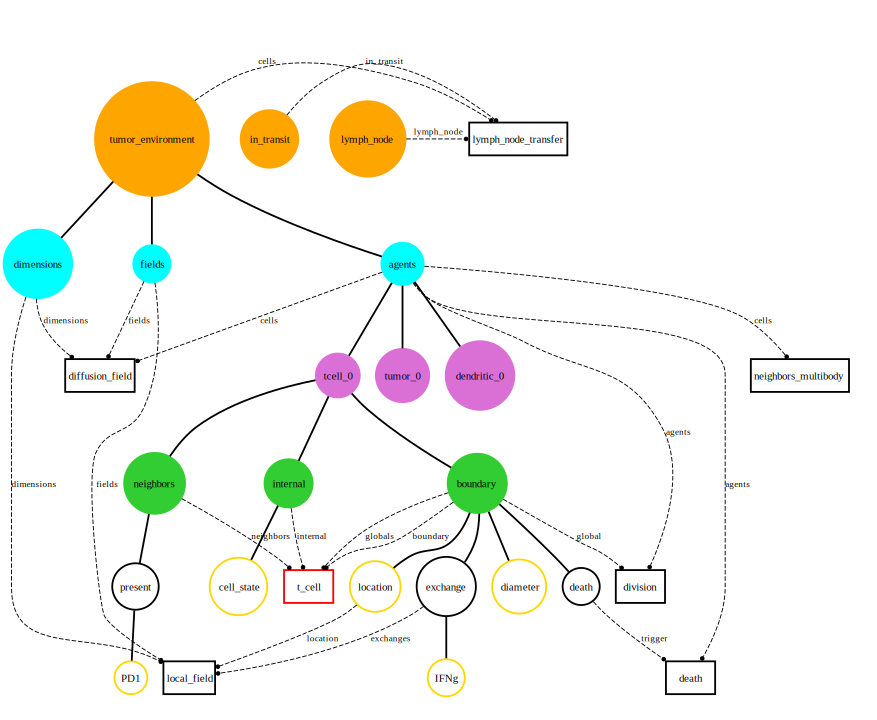

In [69]:
abm_experiment_spec2 = copy.deepcopy(abm_experiment_spec)

# remove some cells for simplicity
abm_experiment_spec2['tumor_environment']['agents']['dendritic_0'] = {}
abm_experiment_spec2['tumor_environment']['agents']['tumor_0'] = {}
internal_spec = {'cell_state': {}}
boundary_spec = {'diameter': {}, 'exchange': {'IFNg': {}}}
neighbors_spec = {'present': {'PD1': {}}}
abm_experiment_spec2['tumor_environment']['agents']['tcell_0']['internal'] = internal_spec
abm_experiment_spec2['tumor_environment']['agents']['tcell_0']['boundary'].update(boundary_spec)
abm_experiment_spec2['tumor_environment']['agents']['tcell_0']['neighbors'].update(neighbors_spec)

# plot full bigraph
node_colors3 = {
    ('tumor_environment', 'agents', 'tcell_0', 'boundary'): c4,
    ('tumor_environment', 'agents', 'tcell_0', 'internal'): c4,
    ('tumor_environment', 'agents', 'tcell_0', 'neighbors'): c4,
}
node_border_colors = {
    ('tumor_environment', 'agents', 'tcell_0', 't_cell'): 'red',
    ('tumor_environment', 'agents', 'tcell_0', 'boundary', 'location'): 'gold',
    ('tumor_environment', 'agents', 'tcell_0', 'boundary', 'diameter'): 'gold',
    ('tumor_environment', 'agents', 'tcell_0', 'boundary', 'exchange', 'IFNg'): 'gold',
    ('tumor_environment', 'agents', 'tcell_0', 'internal', 'cell_state'): 'gold',
    ('tumor_environment', 'agents', 'tcell_0', 'neighbors', 'present', 'PD1'): 'gold',
}
plot_bigraph(abm_experiment_spec2, 
             **plot_settings,
             node_groups=node_groups,
             node_fill_colors={**node_colors0, **node_colors1, **node_colors2, **node_colors3},
             node_border_colors=node_border_colors,
             filename='abm_experiment_tailored',
             remove_process_place_edges=True,
             # **{'out_dir': 'out','dpi': '250'}
            )

## Environment composite

In [70]:
tumor_environment_spec = copy.deepcopy(abm_experiment_spec['tumor_environment'])
tumor_agents_spec = copy.deepcopy(abm_experiment_spec['tumor_environment']['agents'])
tumor_environment_spec['agents'] = {}

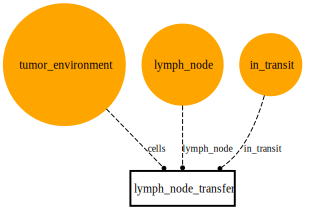

In [71]:
plot_bigraph(lymph_node_transfer, 
             node_fill_colors=node_colors0,
             **plot_settings,
             filename='lymph_node_transfer',
            )

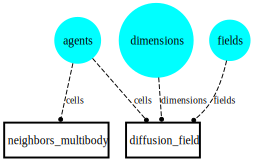

In [72]:
nodec={
    ('agents',): c2,
    ('fields',): c2,
    ('dimensions',): c2,
}

plot_bigraph(tumor_environment_spec, 
             node_fill_colors=nodec,
             **plot_settings,
             filename='tumor_environment',
            )

## Cell Agent composites

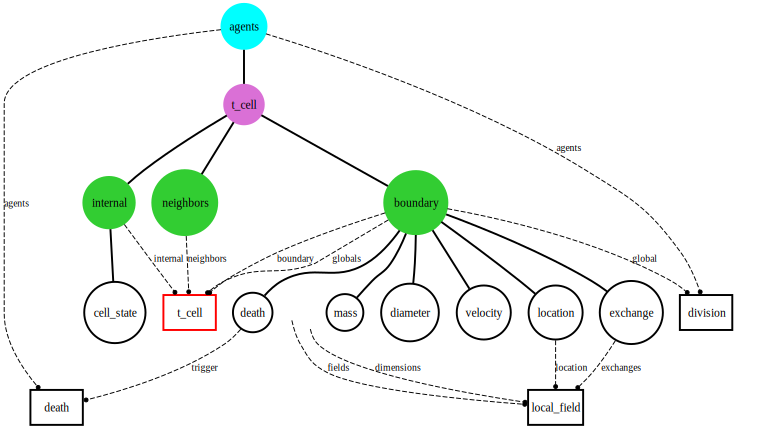

In [83]:
node_groups = [[('agents',)]]
tcell0 = copy.deepcopy(tumor_agents_spec['tcell_0'])
tcell0['local_field']['_ports'] = {'fields': '', 'dimensions': '', 'location': '', 'exchanges': ''}
del tcell0['local_field']['wires']['fields']
del tcell0['local_field']['wires']['dimensions']

internal_spec = {'cell_state': {}}
boundary_spec = {'mass': {}, 'diameter': {}, 'velocity': {}}
tcell0['boundary'].update(boundary_spec)
tcell0['internal'].update(internal_spec)

nodec1 = {
    ('agents',): c2,
    ('agents', 't_cell',): c3,
    ('agents', 't_cell', 'boundary',): c4,
    ('agents', 't_cell', 'internal',): c4,
    ('agents', 't_cell', 'neighbors',): c4,
}
node_border_colors = {
    ('agents', 't_cell', 't_cell'): 'red',
}

plot_bigraph({'agents': {'t_cell': tcell0}}, 
             node_groups=node_groups,
             node_fill_colors={**nodec1},
             node_border_colors=node_border_colors,
             **plot_settings,
             filename='tcell_composite',
             remove_process_place_edges=True,
             # **{'out_dir': 'out','dpi': '250'}
            )

## Stand-alone processes

In [37]:
topology = composite['topology']
tcell_topology = get_in(topology, ['tumor_environment', 'agents', 'tcell_0'])
tumor_topology = get_in(topology, ['tumor_environment', 'agents', 'tumor_0'])
dendritic_topology = get_in(topology, ['tumor_environment', 'agents', 'dendritic_0'])
neighbors_topology = get_in(topology, ['tumor_environment', 'neighbors_multibody'])
diffusion_topology = get_in(topology, ['tumor_environment', 'diffusion_field'])
lymph_node_transfer_topology = get_in(topology, ['lymph_node_transfer'])

### Cell Processes

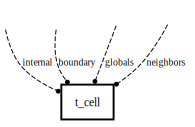

In [38]:
t_cell_spec = {'t_cell': {'_ports': tcell_topology['t_cell']}}
plot_bigraph(t_cell_spec, **plot_settings, filename='tcell_process')

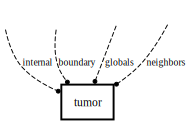

In [39]:
tumor_spec = {'tumor': {'_ports': tumor_topology['tumor']}}
plot_bigraph(tumor_spec, **plot_settings, filename='tumor_process')

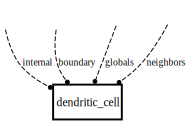

In [40]:
dendritic_spec = {'dendritic_cell': {'_ports': dendritic_topology['dendritic_cell']}}
plot_bigraph(dendritic_spec, **plot_settings, filename='dendritic_process')

### Adapter processes

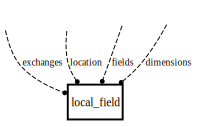

In [41]:
local_field_spec = {'local_field': {'_ports': tcell_topology['local_field']}}
plot_bigraph(local_field_spec, **plot_settings, filename='local_field_process')

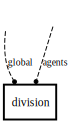

In [42]:
division_spec = {'division': {'_ports': tcell_topology['division']}}
plot_bigraph(division_spec, **plot_settings, filename='division_process')

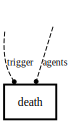

In [43]:
death_spec = {'death': {'_ports': tcell_topology['death']}}
plot_bigraph(death_spec, **plot_settings, filename='death_process')

### Environment processes

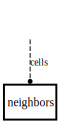

In [44]:
neighbors_spec = {'neighbors': {'_ports': neighbors_topology}}
plot_bigraph(neighbors_spec, **plot_settings, filename='neighbors_process')

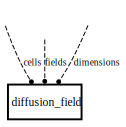

In [45]:
diffusion_spec = {'diffusion_field': {'_ports': diffusion_topology}}
plot_bigraph(diffusion_spec, **plot_settings, filename='diffusion_process')

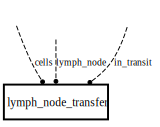

In [46]:
lymph_node_transfer_spec = {'lymph_node_transfer': {'_ports': lymph_node_transfer_topology}}
plot_bigraph(lymph_node_transfer_spec, **plot_settings, filename='lymph_node_transfer_process')